# Projecting conflict risk

In this notebook, we will show how CoPro can use a previously fitted classifier to make projections of conflict risk.

## Preparations

Start with loading the required packages.

In [1]:
from copro import utils, pipeline, evaluation, plots

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.7b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


To be able to also run this notebooks, some of the previously saved data needs to be loaded.

In [3]:
conflict_gdf = gpd.read_file('conflicts.shp')
selected_polygons_gdf = gpd.read_file('polygons.shp')

In [4]:
global_arr = np.load('global_df.npy', allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

### The configurations-file (cfg-file)

In the cfg-file, all the settings for the analysis are defined. Note that the cfg-file can be stored anywhere, not per se in the same directory where the model data is stored (as in this example case). Make sure that the paths in the cfg-file are updated if you use relative paths and change the folder location of th cfg-file.

Note that only a few settings of the cfg-file are needed for making projections. Most relevant is the path to the pickled classifier and the data to be used for the samples matrix (X). For convenience, though, the same file structure can be used and CoPro picks the settings needed.

In [5]:
settings_file = 'example_settings_proj.cfg'

Based on this cfg-file, the set-up of the run can be initialized. Here, the cfg-file is parsed (i.e. read) and all settings and paths become known to the model. Also, the output folder is created (if it does not exist yet) and the cfg-file is copied to the output folder for improved reusability.

In [6]:
config, out_dir = utils.initiate_setup(settings_file)


#### CoPro version 0.0.7b ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2020): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: verbose mode on: False
INFO: saving output to folder C:\Users\hoch0001\Documents\_code\copro\example\OUT_PROJ


## Read data from files

Similar as in the second notebook, we need to collect the variable values for the projection time period. With this data, the samples matrix can be filled. The approach is identical to the reference runs as outlined in a previous notebook. Similarly, the resulting samples matrix is stored to a npy-file. This time, however, we do not have target values (Y) and thus this step is skipped.

Note that for this example notebook, the same input data was used as for the reference data.

In [7]:
X = pipeline.create_X(config, selected_polygons_gdf)

INFO: reading data for period from 2010 to 2015
INFO: entering year 2010
INFO: entering year 2011
INFO: entering year 2012
INFO: entering year 2013
INFO: entering year 2014
INFO: entering year 2015
INFO: all data read
INFO: saving X data by default to file C:\Users\hoch0001\Documents\_code\copro\example\OUT_PROJ\X.npy


## Project!

Before we can make a projection, we need to first get the scaler for the samples matrix again. The pre-computed classifier (based on the reference run) is directly loaded from file as specified in the cfg-file.

In [8]:
scaler, clf = pipeline.prepare_ML(config)

With this all in place, we can use the X-array, the scaler, and the fitted classifier to make a projection whether conflict will take place in a polygon or not.

In [9]:
y_df = pipeline.run_prediction(X, scaler, config)

INFO: scaling the data from projection period
INFO: loading classifier from C:\Users\hoch0001\Documents\_code\copro\example\OUT\clf.pkl
INFO: making the projection


All the previously used evaluation metrics are not applicable anymore, as there are no target values anymore. We can still look which chance of conflict is computed by the model.

In [10]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(y_df, global_df, out_dir=None, make_proj=True)

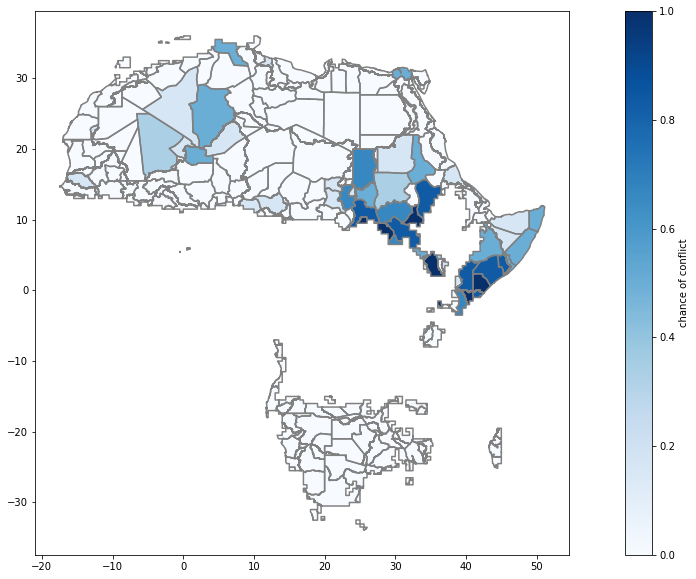

In [12]:
ax = gdf_hit.plot(column='chance_of_conflict', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1,
             legend_kwds={'label': "chance of conflict", 'orientation': "vertical"})
selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

Note that this plot may be different than a similar plot in the previous notebook. This is not unlikely as we use a different amount and different predictions in general here! For instance, we did not repeat the predictions multiple times, nor did we split the data points in training data and test data. Nevertheless, the pattern of projected conflict risk looks very sensible given the outcome of the reference plots.